# Set up frontend dev

In [1]:
%load_ext autoreload
%autoreload 2
import os
import cifar_utils
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
import matplotlib as mpl
%matplotlib notebook
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
%config NotebookBackend.print_figure_kwargs = {'bbox_inches':None}

from traitlets.config.manager import BaseJSONConfigManager
cfg_path = "/Users/crankshaw/anaconda2/envs/clipper/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=cfg_path)
cm.update('livereveal', {
              'theme': 'simple',
              'transition': 'none',
              'start_slideshow_at': 'selected',
              'width': 1024,
              'height': 600,
})

import clipper_manager as cl
ec2_host = "ec2-54-67-123-237.us-west-1.compute.amazonaws.com"
user = "ubuntu"
key = os.path.expanduser("~/.ssh/aws_rsa")
clipper = cl.Cluster(ec2_host, user, key)
clipper.cleanup()
clipper.pull_docker_images()

cifar_path = os.path.expanduser("~/model-serving/data/cifar")
test_x, test_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_test.data", norm=True))
no_norm_x, no_norm_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_test.data", norm=False))


Checking if Docker is running...
Stopping Clipper and all running models...
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/query_frontend:test
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/management_frontend:test
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull redis
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/sklearn_cifar_container:test
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/tf_cifar_container:test
Number of image files: 10000
Number of image files: 10000


<h2 align="center">Is it a bird? Is it a plane? It's probably not Superman...</h2> 
![Alt](superman.png#center)

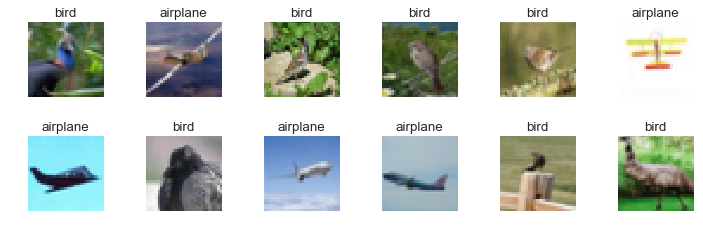

In [2]:
%matplotlib inline
cifar_utils.show_example_images(no_norm_x, no_norm_y, 2)

# Starting Clipper

In [3]:
import clipper_manager as cl
ec2_host = "ec2-54-67-123-237.us-west-1.compute.amazonaws.com"
user = "ubuntu"
key = os.path.expanduser("~/.ssh/aws_rsa")
clipper = cl.Cluster(ec2_host, user, key)

clipper.start_clipper()

Checking if Docker is running...
Clipper is running


In [4]:
clipper.list_apps()

Clipper has no applications registered


# Create an application

In [5]:
app_name = "superman_detection"
candidate_models = [
    {"model_name": "sklearn_cifar", "model_version": 1},
    {"model_name": "tf_cifar", "model_version": 1},
]

clipper.register_application(
    name=app_name,
    candidate_models=candidate_models,
    input_type="doubles",
    slo_micros=20000)

Success!


In [6]:
clipper.list_apps()

superman_detection


# Start serving

```python
def superman_detection_client(uid, x):
    url = "http://{host}/{app}/predict"
    request_json = json.dumps(
        {'uid': uid, 'input': x})
    pred = requests.post(url, request_json)
    return pred
```

<IPython.core.display.Javascript object>


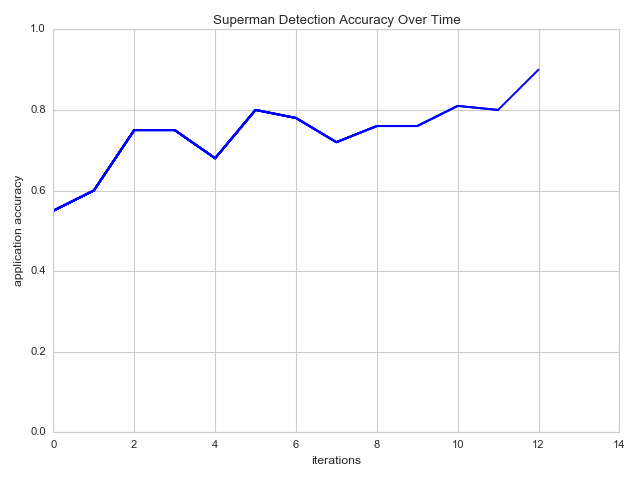

ReadTimeout: HTTPConnectionPool(host='ec2-54-67-123-237.us-west-1.compute.amazonaws.com', port=1337): Read timed out. (read timeout=None)

In [7]:
%matplotlib notebook
cifar_utils.run_serving_workload(ec2_host,
                                 app_name,
                                 test_x, test_y)

So what we've just seen is...

+ Easy for developer to create and query application

+ Easy for data scientist to improve application accuracy while using heterogeneous models

+ Interact with apps and models completely independently